# Section II. MODELING

Chapter 7. Representing Geometry
===============================

So far we have described methods for reasoning about a robot's spatial
reference frames, but have not yet considered the *geometric content* of
those frames, such as the shape and size of the physical structure of
each link. Certainly, it would be wise to consider these geometries when
developing motions and choosing postures, since a robot should avoid
unintentional collision with the environment, and should make contact
when desired. Geometry is also important in robot design, since the
shape of a robot dictates how well it can squeeze into tight locations,
and how much of the surrounding workspace it can reach without
self-colliding.

Mathematical and computational representations of geometry have long
been studied, and a rich set of techniques are in active use today. They
come from a variety of fields, including computer-aided design (CAD),
computational geometry, computer graphics, and scientific visualization
--- and hence this survey only scratches the surface of the vast variety
of geometric representations and calculations.

Example applications
--------------------

Geometry is used pervasively throughout in robotics, including:

-   Mechanism design

-   Physics simulation

-   Collision avoidance

-   Proximity detection

-   Motion planning

-   Calibration

-   3D mapping

-   Object recognition

-   Visualization and performance evaluation

These applications will require some type of *geometric operations* to
be performed on one or more objects, such as:

-   Visualization

-   Collision detection

-   Distance or closest-point computation

-   Ray casting

-   Contact surface computation

-   Penetration depth computation

-   Simplification

-   Shape fitting

-   Storage and transmission

Due largely to decades of work in high-performance, realistic 3D
visualization, many of these operations are extremely fast due to
advances in computing hardware (graphics processing units, or GPUs) as
well as advanced geometric algorithms and data structures. Nevertheless,
it is important for robotics practitioners to understand the performance
tradeoffs in choosing representations appropriate for the desired
operations.

As an example, consider the problem of computing a collision-free
inverse kinematics solution. Assuming we are given 1) an analytical IK
solver, 2) geometric models of each robot link, and 3) a geometric model
of the environment, this problem can be addressed as follows:

1.  Compute all IK solutions.

2.  For each IK solution, run forward kinematics to determine the
    robot's link transforms.

3.  Determine whether the robot's link geometries, placed at these
    transforms, would collide with themselves or the environment.

4.  If any configuration passes the collision detection test, it is a
    collision-free solution.

5.  Otherwise, no solution exists.

The key step is the collision detection in Step 3. If the models are
geometrically complex, collision detection may be a computational
bottleneck. But, if they are too simple to faithfully represent the
robot's geometry, then the computed solution may either miss a collision
(the geometric model is optimistically small) or fail to find valid
solutions (the geometric model is conservatively large).

Geometry representations
------------------------

A geometry $G$ is considered to be some region of space
$G \subset \mathbb{R}^2$ or $\mathbb{R}^3$ depending on whether we are
considering planar or 3D robots. Geometry representations can be
categorized by which part of $G$ is actually represented:

-   *Geometric primitives* like points, lines, spheres, and triangles
    represent a shape $G$ in terms of a fixed number of parameters.

-   *Surface representations* approximate only the boundary of $G$,
    denoted $\partial G$.

-   *Volumetric representations* approximate the entirety of $G$:
    interior, boundary, and exterior.

-   *Point-based representations* store a sampling of individual points
    from $\partial G$.
    
************

![fig:Geometries](figures/modeling/geometries.png)

<div class="figcaption"><a name="fig:Geometries">Figure 1</a>.
The four main classes of geometry representations: (a) geometric primitives, in this case a box with given position, orientation, and dimensions, (b) surface representations, in this case a triangle mesh, (c) volumetric representations, here showing a cutaway view, and (d) point-based representations.</div>

************

There are a number of tradeoffs involved in choosing representations. In
general, surface representations are most widely used for visualization
and CAD, while volumetric representations are most useful for
representing 3D maps and determining whether points are inside or
outside. Point-based representations are widely used to represent raw
data from 3D sensors like lidar and depth cameras. Geometric primitives
are preferred when speed of geometric operations is prioritized over
fidelity.

### Geometric primitives

Primitives are the simplest form of geometric representation, and are
compact, mathematically convenient, and lend themselves to fast
geometric operations: exact calculations can be calculated in constant
($O(1)$) time. (For more information about Big-O notation, consult
[Appendix C.1.](GraphsAndSearch.ipynb#sec:Big-o-notation)) However, they are the least flexible
representation and do not represent most real geometries with high
fidelity.

Common primitives include points, line segments, triangles, spheres,
cylinders, and boxes. For each primitive type, a primitive's shape is
represented by a fixed number of parameters.

-   A **point** is specified by its coordinates $(x,y)$ or $(x,y,z)$.

-   A **line segment** is specified by the coordinates $\mathbf{a}$,
    $\mathbf{b}$ of its end points.

-   A **circle** (in 2D) or **sphere** (in 3D) is specified by its center $\mathbf{c}$ and radius
    $r > 0$.

-   A **triangle** is specified by its vertices $\mathbf{a}$, $\mathbf{b}$, $\mathbf{c}$.

-   A **cylinder** is specified by its base $\mathbf{b}$, primary axis $\mathbf{a}$,
    height $h > 0$, and radius $r > 0$.

-   A **box** is represented by a coordinate frame $T$ with origin at its
    corner and axes aligned to the box's edges, and its dimensions on
    each axis, width/height $(w,h)$ in 2D and width/height/depth $(w,h,d)$ in 3D.

-   An **axis-aligned box** with lower coordinate $\mathbf{l}$ and upper
    coordinate $\mathbf{u}$ contains all points $\mathbf{x} = (x_1,x_2,x_3)$ such
    that $x_i \in [l_i,u_i]$ for $i=1,2,3$.

These representations are not unique, and are chosen by convention. For
example, the origin of a box may be chosen to be its center point rather
than a corner.

### Surface representations

Surface representations (also known as *boundary representations*, or
b-reps) store the boundary of a geometry $\partial G$ without explicitly
representing its interior / exterior.

By far, the most common 3D surface representation is a **triangle mesh**: a
collection of triangles
$(\mathbf{a}_1,\mathbf{b}_1,\mathbf{c}_1),\ldots,(\mathbf{a}_N,\mathbf{b}_N,\mathbf{c}_N)$ that mesh
together to approximate the geometry's surface.  Triangle meshes have two major advantages over other representations:
1) with a sufficient number of triangles, they can approximate arbitrary
surfaces, and 2) graphics hardware is highly optimized for visualization
of large triangle meshes (as of writing, top-end commodity graphics
cards can render over a billion triangles per second).  The 2D equivalent
is a **polygonal chain**.

It is important to note that in order to represent a solid surface, the edges of neighboring triangles in the mesh should be coincident, so that most vertices will be represented in several triangles.  To save on storage space / representational complexity, triangle meshes are often represented as a vertex list $\mathbf{v}_1,\ldots,\mathbf{v}_M$ and a triangle index list $(i_{a1},i_{b1},i_{c1}),\ldots,(i_{aN},i_{bN},i_{cN})$, where the index triple $(i_{ak},i_{bk},i_{ck})$ indicates that the $k$'th triangle is composed of vertices $\mathbf{v}_{i_{ak}},\mathbf{v}_{i_{bk}},\mathbf{v}_{i_{ck}}$. 
For example, the cube in [Fig. 2](#fig:Cube) represents a solid, but only the vertices and triangles of the surface are represented.



************

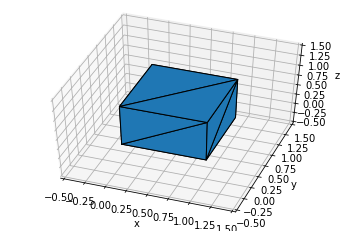

In [1]:
# Code for the triangle mesh visualization
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math

def matplotlib_triangles(ax,vertices,triangle_indices):
    """Adds a 3D triangle mesh, with vertices `vertices` and
    indices `triangle_indices` to the matplotlib plot `ax`.
    """
    #expand triangle indices to matrix of triangle vertices
    triverts = []
    for (a,b,c) in triangle_indices:
        triverts.append((vertices[a],vertices[b],vertices[c]))
    polys = Poly3DCollection(triverts,edgecolor='k')
    ax.add_collection3d(polys)

#triangles for a cube: 8 vertices and 12 triangles, two for each of the 6 faces
vertices = [(0,0,0),
           (0,0,1),
           (0,1,0),
           (0,1,1),
           (1,0,0),
           (1,0,1),
           (1,1,0),
           (1,1,1)]
triangle_indices = [(0,1,3),
                    (0,3,2),
                    (4,6,7),
                    (4,7,5),
                    (0,4,5),
                    (0,5,1),
                    (2,3,7),
                    (2,7,6),
                    (0,2,6),
                    (0,6,4),
                    (1,5,7),
                    (1,7,3)]
    
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(elev=ax.elev+20, azim=ax.azim-10)
matplotlib_triangles(ax,vertices,triangle_indices)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,1.5)
ax.set_zlim(-0.5,1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

<div class="figcaption"><a name="fig:Cube">Figure 2</a>.
A cube is represented by an indexed triangle mesh, given by 8 vertices and 12 triangles.</div>

************

The visualization below loads a triangle mesh from disk, and visualizes it using WebGL. Try spinning it by dragging on it with the left mouse button, and translating it by dragging with the right mouse button.

In [2]:
#Load a chair mesh from disk and visualize it
from klampt import *
vis.init('HTML')
vis.nativeWindow().kw.width = 500
vis.nativeWindow().kw.height = 500
g = Geometry3D()
g.loadFile('data/objects/chair.off')
trimesh = g.getTriangleMesh()
print("Mesh has %d vertices and %d vertices"%(len(trimesh.vertices)//3,len(trimesh.indices)//3))
vis.add('geom',g)
vis.show()

Mesh has 867 vertices and 1719 vertices


Other common surface representations include:

-   **Convex polygons** (in 2D) / **Convex polytopes** (in 3D): represented
    by a list of connected faces, edges,
    and vertices. Also has a volumetric representation in terms of
    *halfplanes* $(\mathbf{a}_i,b_i)$, $i=1,\ldots,N$ such that the geometry
    is determined by the set
    $G = \{ \mathbf{x} \quad |\quad \mathbf{a}_i \cdot \mathbf{x} \leq b_i, i=1,\ldots,N \}$.

-   **Parametric curves** (in 2D) / **Parametric surfaces** (in 3D):  In the 2D case, a function $f(u) : D \rightarrow \mathbb{R}^2$ sweeps out a curve as the parameter varies over a domain $D \subseteq \mathbb{R}$.
    In 3D, a function $f(u,v): D \rightarrow \mathbb{R}^3$ sweeps out the surface as the parameters vary over a
    domain $D \subseteq \mathbb{R}^2$.

-   **Subdivision surfaces**: Defines the surface as a limit of smoothing /
    refinement operations on a polygonal mesh. Used primarily in
    computer graphics.

An important caveat of surface representations is that they may fail to
properly enclose a volume. For example, a triangle floating in
space is a valid triangle mesh, and two intersecting triangles is also a
valid triangle mesh, but neither represents a surface of any enclosed
volume. A triangle mesh that does truly bound a volume is known as *watertight*.
Non-watertight meshes are also known as *polygon soup*.

### Volumetric representations

Volumetric representations have the main advantage of being able to
perform inside / outside tests quickly, and to be able to quickly modify
2D / 3D maps with new information. All of these items store some function $f$
over a ($d=2$ or 3)-D space that indicates whether a point is inside or outside
the geometry.

The function values can be interpreted in several ways, including:

-   **Occupancy map**: a binary function $f : \mathbb{R}^d \rightarrow \{0,1\}$
    where 0 indicates empty space, and 1 indicates occupied space.

-   **Probabilistic occupancy map**: a function $f : \mathbb{R}^d \rightarrow [0,1]$
    where 0 indicates certain empty space, 1 indicates certain occupied space, and
    intermediate values reflect the level of certainty that the space is occupied.
    
-   **Implicit surface**: a function
    $f : \mathbb{R}^d \rightarrow \mathbb{R}$, defined such that
    $f(\mathbf{x}) < 0$ denotes the interior of the object, $f(\mathbf{x}) = 0$ is
    the surface, and $f(\mathbf{x}) > 0$ is the exterior.

-   **Signed distance field** (SDF): an implicit surface
    where $f$ denotes the Euclidean distance to the surface if outside of the
    geometry, or the negative penetration depth if inside the geometry.

-   **Truncated signed distance field** (TSDF): A common variant in 3D mapping,
    which accepts a truncation distance $\tau$. The values of the SDF with absolute
    value $> \tau$ are truncated.

-   **Attenuation / reflectance map**: a function $f : \mathbb{R}^d \rightarrow [0,1]$
    indicates how much a point in space interferes with light, sound, or other signal.

-   **Height field / topograpic map**: Sort of a cross between a surface and volume representation,
    height fields store a 2D function $f(x,y)$ that indicates the height of the surface at the point $(x,y)$.
    This defines a 3D volume over $(x,y,z)$ such that $z > f(x,y)$ indicates empty 
    space, $z=f(x,y)$ indicates the surface, and $z < f(x,y)$ indicates the interior.  Frequently used by
    mobile robots to represent terrain.

The computational representation of the function itself can also vary, including but not limited to:

-   **Combination of basis functions**: $f(x)$ is a linear combination of 
    basis functions $f(x) = \sum_i^m c_i b_i(x)$, where $b_i$ are the (fixed)
    basis functions.  Evaluation is $O(m)$ complexity.
 
-   **Dense pixel / voxel grid**: $f$ is stored a 2D or 3D grid, and evaluating
    $f(x)$ performs a table lookup. For implicit surfaces, $f(x)$ is typically
    evaluated using bilinear / trilinear interpolation of the values at the
    grid vertices.  Evaluation is $O(1)$.

-   **Hierarchical grid (quadtree / octree)**: a hierarchical 2D grid (quadtree) or 3D grid (octree)that
    stores the function at progressively finer levels, up to a given resolution. 
    Evaluation is $O(\log n)$, with $n$ the number of divisions on each
    axis.

-   **Sparse grid / hash grid**: Stores only important cells or blocks of volumetric data, e.g.,
    the occupied cells of an occupancy map, or non-truncated cells of a TSDF.
    Evaluation is $O(1)$.


Some 2D examples are illustrated in [Fig. 3](#fig:Volumetric). 

************

![fig:Volumetric](figures/modeling/volumetric.svg)

<div class="figcaption"><a name="fig:Volumetric">Figure 3</a>.
Volumetric data can be intrepreted and represented in various ways.  Three popular interpretations &mdash; occupancy grids, SDFs and TSDFs &mdash; can be represented as dense, hierarchical, or sparse grids.  Examples are drawn in 2D.</div>

************

Various combinations of value types and representations
are useful for certain tasks. Popular representations include:

- Occupancy grids (occupancy map on a dense voxel grid) are used in the popular
  video game Minecraft to store a map of a 3D world that can be modified in
  unlimited ways.
- Probabilistic occupancy grids (probabilistic occupancy map on a dense pixel grid), used
  in many 2D simultaneous localization and mapping (SLAM) algorithms.
- Occupancy map on an octree, used in the popular OctoMap 3D mapping algorithm.
- TSDF on dense grids, used in small-scale (object or single room) 3D mapping algorithms.
- TSDF on sparse grids, used in large-scale (building-scale) 3D mapping algorithms.
- Attenuation / reflectance grids are used in volumetric medical imaging, like ultrasound, CT,
  and MRI scans, as well as sonar used in underwater and surface vehicles.

All grid-based representations are defined over a volume, usually an
axis-aligned bounding box with corners $\mathbf{l}$, $\mathbf{u}$. The grid will
have size $m \times n \times p$, and converting between world space and
grid space requires a shift and a scale. In particular, the cell indices
$(i,j,k)$ of a point $(x_1,x_2,x_3)$ are determined by a transform
$$\begin{split}
i &= \lfloor m (x_1 - l_1) / (u_1 - l_1) \rfloor \\
j &= \lfloor n (x_2 - l_2) / (u_2 - l_2) \rfloor \\
k &= \lfloor p (x_3 - l_3) / (u_3 - l_3) \rfloor
\end{split}
\label{eq:PointToGridIndices}$$
where $\lfloor \cdot \rfloor$ is the *floor* operation
that returns the largest integer less than or equal to its argument.
(Here we assume zero-based indices.)


### Point-based representations

Point-based representations are widely used in robotics to represent
environment geometries because they are the type of data directly
produced by depth sensors. These representations store a sampling of
points $\mathbf{p}_1,\ldots,\mathbf{p}_N$ from the geometry surface $\partial G$.
Individual points may be associated with colors, normals, and other
information. Usually, this sampling is highly incomplete, exhibiting
irregular density or large gaps caused by occlusion.

There are two major types of point-based representations: **point clouds**
and **depth images** (aka range images). A point cloud is simply an
unstructured list of points with no assumption of regularity. Points are
not a priori identified to objects, nor to each other. This type of
representation results from moving lidar sensors and naively merged
depth scans.

A depth image is a 2D grayscale image indicating the distance from the
camera sensor to the surface observed by each pixel. (Some invalid dpeth
value, such as 0 or $\infty$, indicates no data is available at that
pixel). This is the raw form of data returned from depth cameras ([Fig. 4](#fig:RGBD)). The
advantage of this form of representation over point clouds is that
nearness in the image implies some notion of spatial proximity in 3D
space; furthermore, the line between the camera's focal point and the
read point must be free of other geometry. Algorithms can exploit this
knowledge for faster geometric operations, which we shall see when we
return to the topic of 3D mapping. Knowledge about the camera's position
and orientation in space is required to correlate the 2D image to 3D
points in a global reference frame.

************

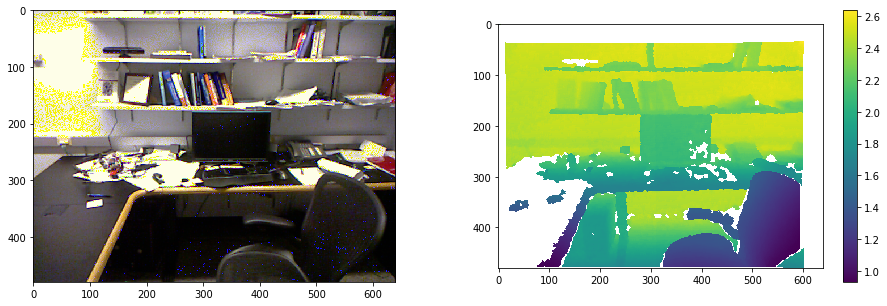

In [3]:
#Code for showing an RGB-D sensor's color and depth image (axis units in pixels, depth units in m)
%matplotlib inline
from klampt import *
from klampt.io import numpy_convert
from matplotlib import pyplot as plt
g = Geometry3D()
g.loadFile("data/objects/point_cloud_scene.pcd")
width = 640
height = 480
pc = g.getPointCloud()
pts = numpy_convert.to_numpy(pc)
assert pts.shape[0] == width*height

"""
vis.init('HTML')
vis.add('g',g,size=0.03)
vis.setViewport({'up':{'x':0,'y':0,'z':1},'position':{'x':-2,'y':0,'z':0},'target':{'x':3,'y':0,'z':0}})
vis.nativeWindow().kw.width = 500
vis.nativeWindow().kw.height = 500
print("Point cloud (click and drag to view)")
vis.show()
"""
from klampt.model import sensing 
import numpy as np
rgbs = sensing.point_cloud_colors(pc,('r','g','b'))
rgbs = np.array(rgbs).reshape((height,width,3))
zs = pts[:,0].reshape((height,width))

fig,axs = plt.subplots(1,2,figsize=(16,5))
axs[0].imshow(rgbs)
depth = axs[1].imshow(zs)
fig.colorbar(depth)
plt.show()

<div class="figcaption"><a name="fig:RGBD">Figure 4</a>.
    A color and depth image captured by an RGB-D camera, from the Cornell RGBD Dataset. The corresponding point cloud can be seen in <a href="#Point-cloud-visualization">Section 4.3</a>.</div>

************


Both point clouds and depth images will be, in general, imperfect
representations of geometry due to sensor noise, occlusion, and limited
field-of-view.


### Accuracy tradeoffs

Except for geometric primitives, each representation can represent
geometry at various levels of *resolution*, such as the density of
triangles in a triangle mesh, or the size of voxel cells in an occupancy
grid. The choice of representation and its resolution should be chosen
to balance several competing demands:

-   Fidelity to the true geometry

-   Appropriateness to desired geometric operations

-   Computational complexity of geometric operations

-   Difficulty of acquisition / creation

-   Implementation complexity

-   Storage and transmission speed requirements

We will discuss several of these aspects below. In terms of fidelity,
however, we can see some general trends. First, 3D surface
representations (e.g., triangle meshes, point clouds) typically need
$O(1/h^2)$ elements to achieve an approximation error of $h$ to a given
surface. Volumetric representations based on a 3D grid will require
$O(1/h^3)$ grid cells, which can be a substantial burden: consider
dividing a 5 m $\times$ 5 m $\times$ 5 m room into centimeter-sized
cells: $500\times 500 \times 500 = 125$ million cells would be needed!
On the other hand, assuming the surface area of the object is
approximately 5 m $\times$ 5 m, a surface-based representation would
only need about 25,000 elements to represent the same object.

The use of more advanced data structures like octrees can compress the
space complexity of volumetric representation to nearly $O(1/h^2)$, but
at the expense of increased complexity of implementing geometric
operations.

### Representing rigid poses and movement

Because it is so common to represent objects as rigid bodies, it is much easier to model the movement of an object as the movement of an rigid body frame, rather than to explicitly modify the geometry itself.  This *implicit transformation* approach is used ubiquitously in robotics, visualization, and computer graphics.  Specifically, we imagine the object to have a local *reference frame*, and define a *local geometry* $G_L \subset R^3$ in the local coordinates.  The object's *pose* is a transformation $T$ from the reference frame to the world frame. As the object moves, $T$ changes, but the local geometry data remains static.  

Hence, we can represent the set of points contained by the object $G(t) \subset R^3$ at time $t$ given only the pose $T(t)$.  The two representations are:

- Explicit transformation: $G(t) = \{ T(t)x \quad|\quad x \in G_L \}$.  (Imagine the points of the local geometry moving with the object's transform.)

- Implicit transformation: $G(t) = \{ x \in R^3 \quad|\quad T(t)^{-1} x \in G_L \}$.  (Imagine the points in world coordinates being projected back into the reference frame.)

Because it is much more efficient to change transforms than geometry data, the implicit transformation approach is preferred in most cases, except perhaps geometric primitives.  For example, if a triangle mesh with 1,000,000 points undergoes a rotation and translation, this can be calculated using 1,000,000 3x3 matrix-vector multiplies and the same number of 3-vector additions. But, in the implicit representation, we can update a transform only by 1 4x4 matrix multiply (using homogeneous coordinates), or 1 3x3 matrix-matrix multiply, a matrix-vector multiply, and a 3-vector addition (using rotation matrix and translation vectors).  Henceforth, we will describe a geometry $G$ in the implicit form as a local-geometry / transform pair $G=(G_L,T)$.  

Proximity queries
-----------------

Proximity queries are an important class of geometric operations for collision avoidance, motion planning, and state estimation.  There are many types of queries, with the following being the most typical in robotics:

- Inside-outside (containment) tests: Return a boolean indicating whether a point $\mathbf{x}$ is
contained within a geometry $G$.
- Collision detection: Return a boolean indicating whether geometries $A$ and $B$ overlap.
- Distance queries / Closest points: Return the distance between geometries $A$ and $B$, or 0 if they overlap.  Usually this requires determining the closest points on each geometry.
- Tolerance queries: Return a boolean indicating whether geometries $A$ and $B$ are within some distance tolerance $\tau$.  If the objects are well-separated, this is usually faster than a true distance query.
- Penetration depth queries: If $A$ and $B$ overlap, return the distance by which one must translate to remove the overlap. 
- Ray casting: Return a boolean indicating whether a ray $\overrightarrow{ab}$ hits geometry $G$. This query may also return the distance $d$ between $a$ and the first-hit point. Used in user interfaces, e.g., to select objects of interest, rendering, and visibility determination.
- Overlap region estimation: If $A$ and $B$ overlap, return a representation of the area or volume of overlap. Used mainly in physics simulation, manipulation, and legged locomotion.

In this book, we describe inside-outside tests and collision detection in more detail for a small number of geometry representations. 

### Inside-outside (containment) tests

Inside-outside testing is a straightforward operation for
primitives and volumetric representations, but not as straightforward
for surface representations.  Note that for a implicitly transformed geometry
$G=(G_L,T)$, this becomes a problem of determining whether the local
coordinates of the point are within the local geometry: $T^{-1}\mathbf{x} \in G_L$.

#### Geometric primitive containment testing

For primitives like spheres, containment can be tested directly from the
mathematical expression of the primitive. For example, a ball with
center $\mathbf{c}$ and radius $r$ is defined by:
$$\| \mathbf{x} - \mathbf{c} \| \leq r.
\label{eq:SphereContainment}$$ An oriented box with coordinate frame $T$
and dimensions $w \times h \times d$ contains all points whose local
coordinates lie in the axis-aligned box
$[0,w] \times [0,h] \times [0,d]$; hence the test for whether a
world-space point lies inside is simply the test:
$$T^{-1} \mathbf{x} \in [0,w] \times [0,h] \times [0,d].$$

#### Volumetric containment testing

Volumetric representations also lend themselves to fast containment
testing. Implicit surfaces, including SDFs and TSDFs, simply require
evaluating the sign of $f(\mathbf{x})$.
Grids have O(1) containment testing by converting the point to
grid coordinates using Eq. $(\ref{eq:PointToGridIndices})$ and
then retrieving the contents of the identified grid
cell. Octrees containment testing is typically logarithmic in the number
of grid cells.

#### Surface containment testing

Surface representations are more challenging since there is no explicit
representation of the object's interior. If it is known that a surface
representation is watertight, then it is possible to *count* the number
of intersections between the surface and a ray whose origin is $\mathbf{x}$
and direction is arbitrary. If the number of intersections is odd, then
the point is inside; otherwise it is outside. 

************

![fig:InsideOutside](figures/modeling/inside_outside.svg)

<div class="figcaption"><a name="fig:InsideOutside">Figure 5</a>.
Left: Inside-outside testing for a point in an arbitrary surface can (normally) be determined by
counting the number of times a ray, eminating from the point, intersects the surface. If this count is odd, the point is inside, while if it is even, the point is outside.  Right: special care must be taken at corner cases, such as when multiple surface primitives intersect the ray, or when the surface is tangent to the ray.</div>

************

There is, however, some
subtlety when the ray lies directly tangential to the surface and/or
passes through an edge of the mesh ([Fig. 5](#fig:InsideOutside), right).
These must be handled when developing a robust algorithm.

### Collision detection between primitives

Collisions between geometric primitives can be computed through
closed-form O(1) expressions. We shall give a couple of useful definitions here.

**Sphere vs sphere**. Two spheres with centers $\mathbf{c}_1$ and $\mathbf{c}_2$ and
respective radii $r_1$ and $r_2$ overlap when the distance between the
two centers is no larger than the sum of the radii:
$$\| \mathbf{c}_1 - \mathbf{c}_2 \| \leq r_1 + r_2.$$

**Sphere vs line**.  A sphere overlaps an infinite line iff the closest point
on the line to the sphere's center falls inside the sphere. Suppose the sphere has center $\mathbf{c}$ and
radius $r$, and the line is given by two points on the line $\mathbf{a}$ and
$\mathbf{b}$. Then, the closest point $\mathbf{p}$ to the center is determined
through projection of $\mathbf{c}$ onto the line:
$$\mathbf{p} = \mathbf{a} + (\mathbf{b} - \mathbf{a})\frac{(\mathbf{c} - \mathbf{a}) \cdot (\mathbf{b} - \mathbf{a})}{\| \mathbf{b} - \mathbf{a} \|^2}.$$
Then, containment of $\mathbf{p}$ is determined
through ($\ref{eq:SphereContainment}$).

**Sphere vs line segment**. Similar to the sphere vs line case, but we must handle
the case in which the closest point from $\mathbf{c}$ to the line defining the segment falls
outside of the endpoints. Let the line segment be defined by endpoints $\mathbf{a}$ and
$\mathbf{b}$.  Notice that the scalar parameter determined by projection
$$u = \frac{(\mathbf{c} - \mathbf{a}) \cdot (\mathbf{b} - \mathbf{a})}{\| \mathbf{b} - \mathbf{a} \|^2}$$
defines what fraction $\mathbf{p}$ interpolates between $\mathbf{a}$ and $\mathbf{b}$.
To restrain $\mathbf{p}$ to the line segment, we can limit $u$ to the range
$[0,1]$. In other words, we compute whether the sphere contains the
point:
$$\mathbf{p} = \mathbf{a} + (\mathbf{b} - \mathbf{a})\max\left(0,\min \left(1,\frac{(\mathbf{c} - \mathbf{a}) \cdot (\mathbf{b} - \mathbf{a})}{\| \mathbf{b} - \mathbf{a} \|^2}\right)\right).$$

**Line segment vs line segment (2D)**. 
For two 2D line segments, defined
respectively by endpoints $\mathbf{a}_1$ and $\mathbf{b}_1$ and endpoints
$\mathbf{a}_2$ and $\mathbf{b}_2$, the collision point can be determined as follows. First, determine
the intersection point of the two supporting lines by solving two
simultaneous equations:
$$\mathbf{a}_1 + u (\mathbf{b}_1 - \mathbf{a}_1) =  \mathbf{a}_2 + v (\mathbf{b}_2 - \mathbf{a}_2)$$
where $u$ gives the interpolation parameter of the first line, and $v$
gives the interpolation parameter of the second line. The solution
$(u,v)$ can be determined through $2\times 2$ matrix inversion:
$$\begin{bmatrix}{b_{1,x} - a_{1,x}} & {a_{2,x} - b_{2,x}} \\ {b_{1,y} - a_{1,y}} & {a_{2,y} - b_{2,y}} \end{bmatrix}\begin{bmatrix} u \\ v \end{bmatrix} = \begin{bmatrix}{a_{1,x}-a_{2,x}} \\ {a_{1,y}-a_{2,y}} \end{bmatrix}$$
If a solution $(u,v) \in [0,1]^2$ exists, then the two line segments
collide. (In 3D, two line segments are unlikely to collide, so this
overdetermined system is unlikely to have a solution.)

**AABB vs AABB**. Two axis-aligned bounding boxes overlap if all of the individual
axis-wise intervals overlap. Two intervals $[a,b]$ and $[c,d]$ overlap
if $a \in [c,d]$, $b \in [c,d]$, $c \in [a,b]$, or $d \in [a,b]$.

************

![fig:Collisions](figures/modeling/primitive_collisions.svg)

<div class="figcaption"><a name="fig:Collisions">Figure 6</a>.
Primitive collision detection, showing (a) sphere vs sphere, (b) sphere vs line segment, with the closest point on the segment's supporting line indicated with a red circle, (c) line segment vs line segment, with the intersection of supporting lines indicated with a red circle, and (d) AABB vs AABB, showing overlap in one dimension but not the other. </div>

************

### Separation principle for convex objects

It is somewhat more challenging to determine whether triangles intersect
each other, or two non-aligned boxes intersect each other. However, we
can use a general *separation principle* that holds between all convex
objects. The principle, illustrated in <a href="#fig:separating_plane">Fig. 5</a>, is as follows:

*If $A$ and $B$ are convex objects, $A$ and $B$ overlap if and only if
there does not exists a plane separating them.*


*************
![fig:separating_plane](figures/modeling/separating_plane.png)

<div class="figcaption"><a name="fig:separating_plane">Figure 7</a>.
    Illustrating the separation principle for 2D objects (left) and 3D objects (right).
    </div>

*************

We can use this fact as follows. Let $\mathbf{n}$ be some direction in space.
Suppose $\mathbf{n} \cdot \mathbf{x}$ over all $\mathbf{x} \in A$ spans the range
$[a,b]$, and $\mathbf{n} \cdot \mathbf{x}$ over all $\mathbf{x} \in B$ spans the range
$[c,d]$. If the projected intervals $[a,b]$ and $[c,d]$ do not
intersect, then we can definitively say that $A$ and $B$ do intersect.

It is straightforward to determine these intervals for a convex polygon
with vertices $\mathbf{v}_1,\ldots,\mathbf{v}_n$.  The projected distances along
$\mathbf{n}$ are $\mathbf{n} \cdot \mathbf{v}_1, \ldots, \mathbf{n} \cdot \mathbf{v}_n$, and we
can simply take the minimum and maximum to determine the projected interval
$[\min_{i=1}^n \mathbf{n} \cdot \mathbf{v}_i, \max_{i=1}^n \mathbf{n} \cdot \mathbf{v}_i]$.

The question is now how to determine which directions $\mathbf{n}$ to use.
For many shapes we can define a finite number of directions
$\mathbf{n}_1,\ldots,\mathbf{n}_k$ such that failure to find a separation along
all directions proves that a the geometries do not overlap. Examples
are as follows.

#### Collision detection between convex polygons in 2D

Suppose convex polygons $A$ and $B$ are respectively given by points
$\mathbf{a}_1,\ldots,\mathbf{a}_m$ and $\mathbf{b}_1,\ldots,\mathbf{b}_n$, listed in
counter-clockwise order. Then, the $i$'th edge of $A$ has an outward
normal direction
$$\begin{bmatrix}{a_{i,y} - a_{(i\mod m)+1,y}} \\ {a_{(i\mod m)+1,x} - a_{i,x}} \end{bmatrix}$$
and the $j$'th edge of $B$ has an outward normal direction
$$\begin{bmatrix}{b_{j,y} - b_{(j\mod n)+1,y}} \\ {b_{(j\mod n)+1,x} - b_{j,x}} \end{bmatrix}$$
where the modulo is needed to ensure proper wrapping around when $i=m$
or $j=n$. Applying the separation principle to all such normal directions
gives a straightforward way to determine whether the polygons overlap.

Another approach, which generalizes to non-convex polygons, is to
calculate segment-segment intersection between each pair of edges along
the polygon. This test fails, however, when one polygon is contained
within another. Hence, to be certain that a polygon does not overlap the
interior of another, we can follow the test by determining whether any
point of A lies within B, and vice versa.

#### Collision detection detween convex polytopes in 3D

3D convex polytopes consist of vertices, edges, and faces. Each edge is
bordered by two vertices and two faces, and each face is bordered by
some number of edges and an equal number of vertices. The approach of
examining for separation along each face of each object runs the risk of
failing to determine separation in certain cases. The problem is that in
3D, the two closest features on the polytope could be two edges, rather
than a point to a face. Hence we must augment the number of directions
examined for separation to handle this case. Specifically, for each
combination of edges $(\mathbf{a}_1,\mathbf{a}_2)$ on $A$ and $(\mathbf{b}_1,\mathbf{b}_2)$
on $B$ we should determine whether separation holds along the direction:
$$(\mathbf{a}_2 - \mathbf{a}_1) \times (\mathbf{b}_2 - \mathbf{b}_1).$$ If separation does
not hold with respect to each normal direction of each face and each
cross product direction, then the two polytopes overlap.

Although this algorithm may be straightforward, it may be quite
inefficient for complex polytopes. A substantially more efficient method
is known as the GJK algorithm. This algorithm maintains a point in each
geometry, $\mathbf{x}_A \in A$ and $\mathbf{x}_B \in B$, as well as which
boundaries are met at the point ([Fig. 8](#fig:GJK)). It proceeds by iteratively "walking"
the points toward one another to reduce the distance between them. Each
step for a point is as follows (the steps for $\mathbf{x}_A$ are shown, they
are symmetric for $\mathbf{x}_B$):

1.  If $\mathbf{x}_A = \mathbf{x}_B$, the polytopes overlap and we are done.

2.  Determine the set of faces $F = \{f_1,\ldots,f_k\}$ met at
    $\mathbf{x}_A$. If the dot product between the direction
    $\mathbf{x}_B - \mathbf{x}_A$ and the normal of a face is negative, remove it
    from $F$.

3.  If $|F| = 0$, then $\mathbf{x}_A$ is an *interior* point. Walk straight
    along the line segment toward $\mathbf{x}_B$ until $\mathbf{x}_A = \mathbf{x}_B$ or
    a boundary is hit.

4.  If $|F| = 1$, then $\mathbf{x}_A$ is on a face. Project the direction
    $\mathbf{x}_B - \mathbf{x}_A$ on the plane supporting the face. Walk along
    this direction until the projected end point is reached, or an edge
    about the face is hit.

5.  If $|F| = 2$, then $\mathbf{x}_A$ is on an edge. Walk along the edge in
    the direction $\mathbf{x}_B - \mathbf{x}_A$ projected onto the edge. Walk
    along this direction until the endpoint is reached, or a vertex is
    hit.

6.  If $|F| \geq 3$, then $\mathbf{x}_A$ is on a vertex. It remains at the
    vertex.

If at two subsequent iterations both $\mathbf{x}_A$ and $\mathbf{x}_B$ fail to
move, then $\mathbf{x}_A$ and $\mathbf{x}_B$ are closest points, and the algorithm
is done.

************

![fig:GJK](figures/modeling/gjk.svg)

<div class="figcaption"><a name="fig:GJK">Figure 8</a>. Illustrating steps of the GJK algorithm. The current points are moved walked incrementally toward one another, respecting the constraints of the currently active feature. The active features for each point are highlighted in blue.
</div>

************

Although $A$ and $B$ may have $m$ and $n$ faces, respectively, polytopes
usually have a constant number of edges per face and faces per vertex.
Because we can track which faces are met at each point, the most
expensive operation in this algorithm is the interior $|F|=0$ case,
where each plane must be checked for intersection with the line segment
$(\mathbf{x}_A,\mathbf{x}_B)$. However, we can show that this operation occurs at
most once. Assuming we can perform the bookkeeping to keep track of
which edge borders which face, which faces border which vertex, etc.
each subsequent step takes constant time. As a result, the entire
algorithm takes $O(m+n)$.

For some tasks, such as physics simulation, we can do even better by
exploiting *temporal coherence* in the movement of each polytope.
Observe that if $A$ or $B$ move just a little bit, the closest points
are likely to be on the same features or on nearby features. Hence, by
keeping track of the closest points and features over time, each update
can be quite fast. In practice, updates are typically $O(1)$.

### Bounding volume hierarchies

For more complex, non-convex representations like triangle meshes, the
approach of checking each pair of primitives defining the objects is
prohibitively expensive. Instead, hierarchical geometric data structures
known as bounding volume hierarchies (BVHs) are used to accelerate
collision detection as well as other geometric operations. The approach
consists of two general ideas.

First, portions of a geometry can be bounded by simple primitive
bounding volumes (BVs), which provides a quick-reject test to eliminate
more expensive computations. Suppose it is known that geometry $A$ lies
entirely within a sphere $S_A$ and $B$ lies within a sphere $S_B$. Then,
if $S_A$ and $S_B$ do not overlap, it is certain that $A$ and $B$ do not
overlap. Spheres and (oriented) boxes are commonly used as primitive
BVs.

Second, a "divide and conquer" approach can be used where if two
top-level BVs overlap, we can divide the two model into portions that
are themselves contained within smaller BVs. This division is performed
recursively, leading to smaller and smaller portions of the model until
individual primitives are left. The BVH stores all of these BVs in a
hierarchical data structure (a tree) with the top level bounding volume
(the root) containing the entire model, and the lowest level (the
leaves) containing individual primitives. The BVH is precomputed for a
given model and then reused during collision detection.

*************
![fig:bounding_volume_hierarchy](figures/modeling/bounding_volume_hierarchy.svg)

<div class="figcaption"><a name="fig:bounding_volume_hierarchy">Figure 9</a>.
    A bounding volume hierarchy for a 2D W-shaped object, with circles as bounding volumes.  The leaf nodes contain individual line segments.
    </div>

*************


#### BVH representation and computation

A BVH is a hierarchical data structure $H$ defined with respect to the local frame
of each geometry (recall the implicit representation $G=(G_L,T)$).  The contents of a 
leaf node $N$ are a portion of $G_L$, such as the lowest-level primitives of a triangle mesh
or point cloud.  A non-leaf node $N$ is associated with a subset geometry $G_L(N)\subseteq G_L$
contained in the leaves of the subtree of $N$.  $N$ stores a bounding volume $B(N)$, which is a geometric
primitive (defined in the local frame) that is guaranteed to contain all of $G_L(N)$.
The children of $N$ contain smaller subsets of $G_L(N)$, while for the root node $G_L(N)=G_L$.

Note that if the geometry moves according to a rigid transform, the precomputed BVH still
applies to the local geometry, with the implicit understanding that any collision computations
will take place in the world frame.  In other words, we delay transforming any primitives and
bounding volumes to the world frame until just before each geometric operation takes place.

The BVH structure is an important determinant of ultimate collision query performance.
For best performance, we would like the BVH to satisfy several properties:
1. *Balanced*. The BVH should be a balanced tree to minimize its height.
2. *Tightness*. The BVs of non-leaf nodes $N$ to be tightly wrapped around the geometry
   $G_L(N)$ contained therein, so that portions of the geometry can be pruned quickly.
3. *Spatial coherence*. Child BVs should contain portions of the geometry that are separated
   as far as possible to encourage fast pruning. (This is related to tightness.)

A BVH is typically created either in top-down or bottom-up fashion.  Top-down construction
uses a recursion on a subset $S \subseteq G_L$, which is initially set to $S=G_L$ itself. 
If $S$ is small enough (contains one or a few primitives), then a leaf node $N$ is output with $S$
as its contents.  Otherwise, the BV for $S$ is constructed, a non-leaf node $N$ is instantiated,
and the children are $N$ are recursively constructed by subdividing $S$ into two (or more) parts.
To encourage tightness and spatial coherence, one approach is construct the subdivision by finding a
dividing plane, and create two children containing primitives on either side of the plane. To
encourage balance, the dividing plane should approximately divide $S$ into two subsets of equal size.

In bottom-up fashion, a leaf node is constructed for each primitive. Then, pairs of
nearby or highly overlapping nodes are aggregated into non-leaf nodes.  This process repeats
until only one node remains (the root).  There is a choice here about how to construct a BV of two
aggregated nodes.  Either the BV could be constructed by bounding the children BVs (looser but faster), or by bounding the underlying geometry (tighter but slower).

Both processes are relatively expensive, with top-down computation taking at least $O(n h)$ time,
where $h$ is the height of the BVH tree, and bottom-up computation taking at least $O(n \log n)$ time,
depending on how efficiently pairwise aggregation can be performed.  However, the expense is worthwhile
particularly if it can be amortized over many collision queries.

If the geometry $G_L$ itself changes frequently, then the BVH must be recomputed.  If the change is slight,
then the same tree structure can be reused with only minor changes to the BVs.  For example, for non-rigid
deformations, the BVs can be recomputed in bottom-up fashion to reflect the new geometry after
transformation.  However, if the change is drastic, then the BVH should be computed from scratch. For example,
if a straight rope gets tied into a bow, then an optimal BVH for the bow would group together the parts
of the rope that are knotted.

#### BVH queries

To check collision between two BVHs $H_A$ and $H_B$, the following operations are
performed recursively, starting at the root BVs.

1.  If the two BVs do not overlap, return "no collision".

2.  If the two BVs are leaves, test their contents for collision. If a
    collision exists, return "collision".

3.  Otherwise, pick one of the BVs and recurse on both of its children.
    If either call returns "collision", then return "collision".

(Note: each collision query is performed in world space by transforming the local BVs to world coordinates.)

In step 3, a simple heuristic is to choose the larger of the two BVs.
Furthermore, we should choose which child to recurse on first in order
to find a collision faster, if one exists. (If the objects collide,
recursing on the correct child first may eliminate unnecessary
computation with the second child; if they don't collide, both children
will need to be checked anyway.) One such heuristic is to start with the
child with the greatest volume of overlap with the un-split BV.

Other proximity queries, like distance queries and ray casting, can also be
greatly accelerated by BVHs.  These are left as exercises for the reader.

#### Performance

The BVH approach has been extremely successful in practice, and is
implemented in several widely used collision detection
packages, such as PQP and FCL. Computational performance is generally
quite good: on modern PCs, millions of collision checks can be performed
per second between meshes consisting of thousands of triangles.

However, the computation cost does vary with the spatial proximity of the
objects. If the objects are far from each other, the algorithm is quite
fast because only the top level BVs will be checked. If the objects are
highly overlapping, then the heuristic will likely lead the search to
find a collision quickly, and typically takes logarithmic time. The most
expensive case is when the objects have many primitives that are very
close to colliding, but not quite.

### Broad phase collision detection

The above discussions applied only to pairs of geometries. If $n$
objects are moving simultaneously, then it may be quite expensive to
check all $n(n-1)/2$ pairs ($O(n^2)$ time). The process of eliminating
pairs of objects from consideration, before performing more detailed
collision checking, is known as *broad phase collision detection* and
can lead to major performance improvements when $n$ is large.

One simple method for broad phase collision detection is a *spatial
grid* method, and is most applicable for objects of relatively similar
size. Assume that all objects have diameter $d$, and relatively few
objects overlap. Then, we can construct a grid where each cell has
dimensions $d \times d \times d$, and each cell contains a list of
objects whose center lies inside it. This grid can be constructed in
$O(n)$ time, particularly when using a sparse data structure like a hash
table.

Then, to query for collisions, we loop through all grid cells, and only
check collision between objects contained in a cell and each neighboring
cell (for a total of 9 cells in 2D and 27 cells in 3D). If the number of
objects whose center lies in a grid cell is bounded by a constant, then
all pairs of potentially colliding objects can be determined in $O(n)$
time.

This basic scheme can be extended to objects of varying size, or varying
query sizes.  For example, [Fig. 10](#fig:broadphase) shows an
application to crowd simulation, in which each agent only needs to consider
interacting with agents within some "proximity radius".

*************

![fig:broadphase](figures/modeling/broadphase.svg)

<div class="figcaption"><a name="fig:broadphase">Figure 10</a>. 
    Broad phase collision detection / proximity for crowds (disks) with a "proximity radius" (dotted lines).  Left:  Yellow objects have sufficiently close proximity so that the proximity radius of object A overlaps the disk of object B. Red objects collide.  Right: a grid data structure can be constructed so that an object's disk is added to each grid cells that the disk overlaps (shaded grey). The cells overlapped by a query proximity disk (bold) are highlighted in blue, and in this case only three disks, excluding the query object, need checking for collision.
    </div>

*************

Visualization
-------------

It is important to be able to visualize geometric models, and the chosen
representation does effect the performance, realism, and clarity of a
visualization. Note that some systems may represent objects'
visualization geometries separately from the geometries used for
collision detection to make collision detection queries faster; this
is typical in the URDF files used in ROS (<a href="#fig:vis_coll_geometry">Fig. 11</a>).

*************

| (a) High-resolution visualization geometry | (b) Lower-resolution collision geometry
|---------------------------------------------------------------|--------------------------------------------------------|
|![fig:hubo_vis](figures/modeling/hubo_visualization_geometry.png) | ![fig:hubo_col](figures/modeling/hubo_collision_geometry.png) |

<div class="figcaption"><a name="fig:vis_coll_geometry">Figure 11</a>. 
    Visualization geometry for robots may be stored separately from the collision detection geometry, and may contain more details to improve the quality of visualization.
    </div>

*************

### Rasterization

The basic operation performed by commodity graphics cards is known as
*rasterization*, in which triangles are drawn, pixel by pixel, into the
image shown on a computer screen.  The most common frameworks for doing
so are the OpenGL (multi-platform) and DirectX (Windows) APIs.

For optimal performance, static or rigidly transforming triangle meshes
should be uploaded (once) to the computer's graphics processing unit (GPU).
Doing so, modern GPUs can render scenes composed of tens of millions of
triangles per frame at real-time rates.
Deforming triangle meshes require data to be transferred to the GPU
whenever they change, which incurs a performance penalty.

To use rasterization methods to render non-triangle
mesh data, the geometry representation must be converted to triangle
mesh form. Methods for doing so will be discussed in <a href="#Geometric-conversions">Section 5</a>.

Colors, lighting, textures, shadowing, and other visual effects may be
applied as well to obtain more realistic-looking results. Colors and lighting
can be computed on GPUs with relatively straightforward calculations.  However, 
more sophisticated effects like transparency and shadowing require carefully
designed rasterization
pipelines.  Graphics engines such as Unity, Unreal Engine, Blender, Ogre3D,
and Three.js provide such functionality in a relatively easy-to-enable manner. 
But designing such pipelines from scratch, e.g., using OpenGL or DirectX, is
an advanced subject studied in computer graphics, and is beyond the scope of
this book.

### Volumetric rendering

The most common method for visualizing volumetric geometries is to
convert the volume to a surface representation and use rasterization
techniques. However, it is worth mentioning some other methods for
visualizing volumetric data developed for scientific visualization and
computer graphics.

*Ray-casting* methods imagine a ray emanating from each pixel in the
screen, and march along through space until a surface is hit. The method
is used in computer graphics to render shadows and transparency, as well
as for volumetric rendering. Complex visual phenomena like absorption,
scattering, and self-shadowing can be simulated using these techniques.

*Volumetric texturing* methods treat the volume as a 3D texture and
rasterize slices through the volume. This approach makes advanced use of
modern GPUs to obtain faster frame rates than ray-casting methods.

### Point cloud visualization

Point clouds can be somewhat challenging to visualize sensibly because
the data is distributed with non-uniform sparsity, with missing patches
due to occlusion, and spurious noise. If color information is
unavailable, simply rasterizing points tends to obscure shape due to the
lack of visual cues like lighting. As a result a point cloud,
particularly when viewed from oblique angles, will look fairly strange,
and will display portions of the objects that should be hidden from
view (<a href="#fig:point_cloud">Fig. 12</a>). 

*************

| (a) A point cloud, from a similar vantage point to the camera | (b) A close up of the desk, from another vantage point|
|---------------------------------------------------------------|--------------------------------------------------------|
|![fig:point_cloud](figures/modeling/point_cloud.png) | ![fig:point_cloud2](figures/modeling/point_cloud2.png) |

<div class="figcaption"><a name="fig:point_cloud">Figure 12</a>. 
    A point cloud of an office scene from an RGB-D camera, from the Cornell RGBD Dataset. Away from the original camera's vantage point, the data is difficult to interpret.
    </div>

*************

A variety of techniques have been developed to make point cloud
visualization more interpretable, such as false color, which encoding
$x$, $y$, $z$ position as some sort of color; billboarding which
visualizes a small patch of geometry like a square or disk at each
point; or splatting, which fills in space between points to make the
image appear like a solid object.


Geometric conversions
---------------------

Given that some geometric operations are more suited to certain
representations than others, it is often necessary to perform
conversions between representations. It is also often necessary to
perform modifications to an existing representation for purposes of
computational efficiency, or limitations of storage / transmission
channels.

### Surface to triangle mesh

Alternate surface representations are often converted to triangle meshes
for visualization, collision queries, and compatibility. Parameterized
surfaces can be converted to triangle meshes by defining a grid in
parameter space, and computing triangles connecting the points on the
grid. The resolution of the grid should be chosen carefully to balance
computational complexity and geometric fidelity requirements.
Subdivision surfaces maintain a polygonal mesh, and by performing
recursive subdivision and smoothing operations, the mesh is
progressively modified toward a limiting smooth surface. The recursion
stops when a desired resolution level is met.

### Volume to surface

Implicit surfaces are typically converted to triangle meshes by the
*marching cubes* algorithm . First, if the implicit function is not
already in grid form, a grid containing the geometry is defined and the
surface evaluated on each of the grid points. Then, the algorithm
"marches" along each cell, and if the function values of the 8 vertices
of the cell contain both positive and negative values, then the 0
isosurface passes through the cell. For cells containing the surface,
marching cubes generates anywhere from 1 to 4 triangles within the cell
that separate the positive and negative vertices from each other.
Repeating this for each cell through the volume produces a watertight
isosurface.

Occupancy grids are often converted to triangle meshes by outputting a
rectangle when an occupied cell borders an unoccupied one. This has the
effect of creating a jagged "stair step" appearance because each face is
axis-aligned.

*************

TODO: illustration of marching cubes
<div class="figcaption"><a name="fig:MarchingCubes">Figure 13</a>. 
    TODO
    </div>

*************

### Surface to volume

It is typically harder to convert between surface and volume
representations due to subtle resolution issues, and furthermore when a
surface is non-watertight it is not even clear what an appropriate
volume should be.

#### From surface to distance field

In the watertight surface case, the *fast marching method* (FMM) can be
used to produce a signed distance field. The first step of FMM is to
define a grid containing the surface, and identify all of the surface
cells. The signed distance from each grid vertex to the surface is then
computed. These seed values are stored in a priority queue, ordered by
increasing absolute distance. Additionally, each grid vertex is labeled
as either *far*, *considered*, or *accepted*, depending on whether the
value at that vertex is not considered yet, tentatively assigned but
potentially changing in the future, or fixed.

The seed values are initially marked as accepted. Then, the algorithm
proceeds to establish distance values throughout the whole volume in
"brush fire" fashion, with the invariant that a vertex is only accepted
when all possible direct paths to it from the surface have been
considered. The iteration performs the following steps: 1) the grid
vertex in the queue with least distance is chosen, and it is marked as
accepted, 2) using its distance value, the distance field is
extrapolated to its un-accepted neighbors. During step 2, far neighbors
are marked as considered, and the distance of a considered vertex is
modified only if the extrapolated value is less than the previously
stored values. This continues until all vertices are accepted.


*************

TODO: illustration of fast marching method
<div class="figcaption"><a name="fig:FMM">Figure 14</a>. 
    TODO
    </div>

*************

Given a suitably defined queue data structure, the overall running time
of the algorithm is $O(N \log N)$ where $N$ is the number of grid cells.
The major caveat with this algorithm is that the initial determination
of inside and outside vertices is sensitive to the grid resolution, and
if there are features of the surface smaller than the grid cell size,
this may lead to an inconsistent propagation of inside / outside cells.

#### Implicit surface fitting

Another class of volumetric construction methods attempts to fit an
implicit surface function to the surface data. In one common form, an
implicit function can be defined as a sum of $N$ *radial basis
functions* : $$f(\mathbf{x}) = \sum_{j=1}^N w_j \phi(\| \mathbf{x} - \mathbf{c}_j \|)$$
where each basis function is defined by the *kernel* $\phi$ and the
center $\mathbf{c}_j$. Here $w_j$ is the weight associated with the $j$'th
basis function. Common functions for $\phi$ include the linear kernel
$\phi(r) = r$, the Gaussian kernel $\phi(r) = e^{-b r^2}$ with $b$ a
constant parameter, and the thin plate spline kernel
$\phi(r) = r^2 \log r$.

If we are given $N$ desired function values $f_i$ at points $\mathbf{x}_i$,
$i=1,\ldots,N$, then the weights $w_1,\ldots,w_N$ can be tuned so that
the function meets those values: $f(\mathbf{x}_j) = f_j$. This fitting is
performed by solving a linear system of equations:
$$\begin{bmatrix}
\phi(\|\mathbf{x}_1 - \mathbf{c}_1 \|) & \cdots & \phi(\|\mathbf{x}_1 - \mathbf{c}_N \|) \\
\cdots & \ddots & \cdots \\
\phi(\|\mathbf{x}_N - \mathbf{c}_1 \|) & \cdots & \phi(\|\mathbf{x}_N - \mathbf{c}_N \|) 
\end{bmatrix}
\begin{bmatrix}{w_1} \\ {\cdots} \\ {w_N} \end{bmatrix} = \begin{bmatrix}{f_1} \\ {\cdots} \\ {f_N} \end{bmatrix}$$

It is then a matter to decide where to place the evaluation points,
desired function values, and basis function centers. Certainly, placing
points on the geometry surface such that $f(\mathbf{x})=0$ ensures that the
implicit surface will pass through these points. However, these points
are insufficient, because this leads to the trivial solution
$w_1,\ldots,w_N = 0$. An additional constraint is to keep points outside
of the geometry to be positive, and some points inside the geometry to
be negative. Commonly, these are points offset from the surface along
the normal direction. To place the centers, one commonly used technique
is to assume the evaluation points and centers shall coincide:
$\mathbf{x}_i = \mathbf{c}_i$.

These techniques are susceptible to numerical difficulties when $N$ is
large and the evaluation points are close together, since the matrix to
be inverted becomes large and ill-conditioned. Running times also suffer
with large $N$. More advanced approaches have been developed to overcome
these issues, such as using basis functions that lead to a sparse
matrix, or fitting many local implicit surfaces over local regions and
then combining their results.

#### Space carving

Space carving techniques will be described in more detail when we
discuss 3D mapping, but here we shall give a short overview. The idea is
start with a fully occupied occupancy grid, and then to imagine taking
views of the surface from multiple angles. For each point in the view,
free space is "carved" out of the occupancy grid by marching along a ray
emanating from the viewpoints and terminating once the object's surface
is reached.

After many views are simulated, the resulting occupancy grid contains
the object and matches its silhouette from multiple angles. It is also
possible to modify the method slightly to define an approximate signed
distance function. It should be noted, however, that space carving
methods do not faithfully represent objects with interior cavities or
deep holes that are difficult to see from a distant exterior view.

### Point cloud to surface

Point clouds can be converted to surfaces in a few ways, but this
operation is not trivial because it is not immediately clear simply from
the coordinates of a set of points whether they belong to the same
surface. As a result, each of these techniques is prone to certain
artifacts.

For depth images, it is a simple matter to view the image as a triangle
mesh grid and then to assign coordinates to the vertices of the mesh
using the depth values and camera transform. Discontinuities in depth
can be assumed to be caused by disjoint objects, and triangles
corresponding to those discontinuities can be deleted from the mesh.

Another class of techniques first builds a volumetric representation,
such as by implicit surface fitting or space carving, and then converts
back to a triangle mesh using marching cubes.  One such popular technique is known as Poisson reconstruction.

A final class of techniques attempts to build a triangle mesh directly
from the point cloud. Some geometric criterion is used to define whether
a particular candidate line (in 2D) or triangle (in 3D) connecting
points should be included in the surface. Examples of such criteria are
$\alpha$-shapes, Delaunay triangulations, and the Voronoi diagram. These
methods generally assume that the sampling of points on the surface is
sufficiently dense so that, loosely speaking, surface elements are
smaller than non-surface elements. 

### Simplification

Geometry can be simplified in a number of ways for improved
computational performance and compact storage / transmission. Point
clouds and volumetric representations can be downsampled or averaged to
obtain a coarser resolution. Triangle meshes can be simplified in a
number of ways. Decimation collapses vertices and/or edges to obtain
progressively fewer triangles while attempting to maintain high quality.
Clustering methods break the mesh into pieces and then replaces the
pieces with simplified re-meshed geometry. A mesh could also be
converted into a volumetric representation of a given resolution, and
then the surface could be extracted.

## Software

There are many software libraries for handling geometric computations, including:

- Low-level rasterization: [OpenGL](https://opengl.org/) (C, with bindings for other languages), [DirectX](https://en.wikipedia.org/wiki/DirectX) (C++), [WebGL](https://www.khronos.org/webgl/wiki/Main_Page) (Javascript, based on OpenGL)

- Medium-level visualization, scene graph libraries: [OpenSceneGraph](http://www.openscenegraph.org/) (C++), [OGRE](https://www.ogre3d.org/) (C++), [VTK](https://vtk.org/) (C++,Tcl/TK,Python,Javascript), [PyInventor](https://thehubbit.github.io/PyInventor/) (Python), [Three.js](https://threejs.org/) (Javascript)

- High-level game engines: [Unity](https://unity.com/) (C#), [Unreal Engine](https://www.unrealengine.com/) (C++)

- Collision detection: [FCL](https://github.com/flexible-collision-library/fcl) (C++), [Bullet](https://github.com/bulletphysics/bullet3) (C++, Python), [Shapely](https://github.com/Toblerity/Shapely) (Python, 2D only)

- Point cloud processing: [PCL](https://pcl.org) (C++), [Open3D](http://www.open3d.org/) (Python)

- Multifunction: [Klamp't](http://klampt.org) (C++, Python) provides [visualization and scene-graph](http://motion.cs.illinois.edu/software/klampt/latest/pyklampt_docs/Manual-Visualization.html) functionality, [collision detection](http://motion.cs.illinois.edu/software/klampt/latest/pyklampt_docs/Manual-Geometry.html#collision-detection), and [geometric conversion](http://motion.cs.illinois.edu/software/klampt/latest/pyklampt_docs/klampt.robotsim.html#klampt.Geometry3D.convert) tools.

There are also a plethora of standalone programs for authoring, editing, capturing, and processing geometries.

- 3D modeling: Blender (free), Sketchup (free), Autodesk Fusion, Solidworks

- 3D mesh / point cloud editing : Meshlab, VRMesh, CloudCompare


Summary
-------

Key takeaways:

-   The four main types of geometry representations are primitives,
    volumes, surfaces, and points.

-   Each representation has certain strengths and weaknesses with
    regards to the storage complexity, time complexity, and accuracy of
    operations that can be calculated upon them.

-   Collision detection can be performed using mathematical operations
    for primitive objects, the separation principle for convex objects,
    or bounding volume decompositions for compound objects.

-   Conversions between representations is often easiest from volume to
    surface and from surface to points, while the reverse is much
    harder.

Exercises
---------

1.  Write pseudocode to fully develop the convex polygon-polygon
    collision detection algorithm <a href="#Collision-detection-between-convex-polygons-in-2D">described above</a>. What is the time
    complexity of this algorithm? Your answer should be in terms of $m$
    and $n$, the number of vertices of each polygon.

2.  Write pseudocode to fully develop the polygon-polygon collision
    detection algorithm for *non-convex polygons* briefly <a href="#Collision-detection-between-convex-polygons-in-2D">described above</a>. What is the time
    complexity of this algorithm? Your answer should be in terms of $m$
    and $n$, the number of vertices of each polygon.

3.  Devise pseudocode for determining whether a point cloud intersects
    with an implicit surface, both of which are represented in
    implicitly-transformed fashion.  (A brute-force method is fine.)  Can you
    generalize this pseudocode to other types of geometry, provided
    that an inside-outside containment tester is given? 

4.  Implement the grid-based broad-phase collision detection technique
    described in <a href="#broadphase">Section 3.5</a> for disk-shaped objects. 
    Compare the running time of this algorithm with the brute-
    force collision detection with varying numbers of objects, added
    at random.

5.  Investigate what geometry representations can be imported and
    exported from a CAD program (e.g., Solidworks, AutoCAD). Investigate
    what geometry representations are directly available from an RGB-D
    camera (e.g., Microsoft Kinect, Intel Realsense). Investigate what
    geometry representations are used in a 3D mapping program (Google
    Project Tango, Pix4D, AutoCAD Map 3D).

6.  Suppose that you are implementing a 3D mapping algorithm for mobile indoor robots
    and wish to map volumes between 5m x 5m x 4m (single room) up to
    200m x 200m x 30m (multiple floors of a building).  Specify the memory requirements
    for a 3D grid representation, a triangle mesh representation, and a point cloud
    representation.  Suppose that you store RGB colors in a 32-bit integer, positions
    (if necessary) as single-precision floating point numbers, and desire a map with
    spatial resolution of 5cm. 

7.  A bounding volume hierarchy can be defined with different types of shapes.  Consider
    the pros and cons of using 1) spheres, 2) axis-aligned bounding boxes, and 3) oriented boxes.
    Which shape(s) is expected to have the tightest fit to the geometry?  Which shape(s) has the fastest
    bounding volume / bounding volume collision test?  Which shape(s) do not need to be
    explicitly updated when the geometry undergoes a rigid transformation?

8.  Experimentally investigate the running time of bounding volume
    hierarchy collision detection software. First, examine how
    precomputation time varies with the complexity of the model. Is the
    running time linear, quadratic, or something else? Next, examine how
    query time varies with the complexity of the two models and their
    proximity. Explain your observations in terms of how many bounding
    volumes are checked.

9.  Write pseudocode for performing a ray-cast query for a triangle mesh in brute-force fashion.
    Assume a subroutine is available for computing ray-triangle intersections, called
    `rayTriangleIntersect(a,b,triangle)` where `a` is the ray start point, `b` is a point along
    the ray, and it returns the distance `d` to the intersection point if there is an intersection,
    and returns `d=`$\infty$ if there is no intersection.
    Then, write pseudocode for an accelerated version a using a bounding volume hierarchy. Assume
    a subroutine is available for compute ray-BV intersections, called `rayBVIntersect(a,b,BV)`.

10. An autonomous vehicle or wheeled mobile robot will sense an environment
    in 3D, but navigates essentially on a 2D semi-planar ground.  Suppose 
    that a laser sensor is used to provide information about the ground surface
    and obstacles in the form of a 3D point cloud.  Suppose the robot knows where
    it is, and where its sensor is located on its chassis.  What processing
    steps would need to take place to convert the 3D data into a 2D obstacle map
    assuming that the ground was almost entirely flat (say, with height variation
    below 2cm)?  What would complicate this process if the ground is not flat,
    such as curbs, hills, speed bumps, and ramps?  What information might be available in the point
    cloud for you to treat curbs as obstacles, but not hills, speed bumps, and ramps?  What complications
    would arise when due to the nature of point cloud data?

## Interactive quiz

In [3]:
#This code must be run from the RoboticSystemsBook folder
from IPython.display import display,Markdown
from rsbook_code.assessment import quiz
quiz.show_geometry()